<a href="https://colab.research.google.com/github/regismunez/CienciaDatosEjemplos/blob/main/implementacionDNNyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 3: IMPLEMENTACIÓN DE DNN Y CNN
autor: regis munez 2025


# Fase 1: Preparación del entorno y librerías
Instalar y configurar librerías:

    PyTorch: torch, torchvision, matplotlib
    TensorFlow: tensorflow, keras, matplotlib

Fijar semillas para reproducibilidad.

In [1]:
# import sys
# !{sys.executable} -m pip install torch torchvision torchaudio

# Importaciones comunes
import matplotlib.pyplot as plt
import numpy as np
import os

# Para reproducibilidad
SEED = 42
np.random.seed(SEED)

# ========== PYTORCH ==========
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.manual_seed(SEED)

# ========== TENSORFLOW ==========
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

tf.random.set_seed(SEED)

print("✅ Librerías importadas correctamente")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")

✅ Librerías importadas correctamente
PyTorch version: 2.8.0+cu126
TensorFlow version: 2.19.0


# Fase 2: Carga y preprocesamiento de CIFAR-10
Convertir imágenes a tensores y normalizar:

    PyTorch: transforms.Normalize() por canal.
    TensorFlow: dividir por 255 y estandarizar.

Separar en entrenamiento y prueba, manteniendo balance de clases.

=== PREPROCESAMIENTO PyTorch ===


100%|██████████| 170M/170M [00:02<00:00, 63.5MB/s]


PyTorch - Entrenamiento: 50000 imágenes
PyTorch - Prueba: 10000 imágenes

=== PREPROCESAMIENTO TensorFlow ===
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


TensorFlow - Entrenamiento: 50000 imágenes
TensorFlow - Prueba: 10000 imágenes
Shape de imágenes: (32, 32, 3)


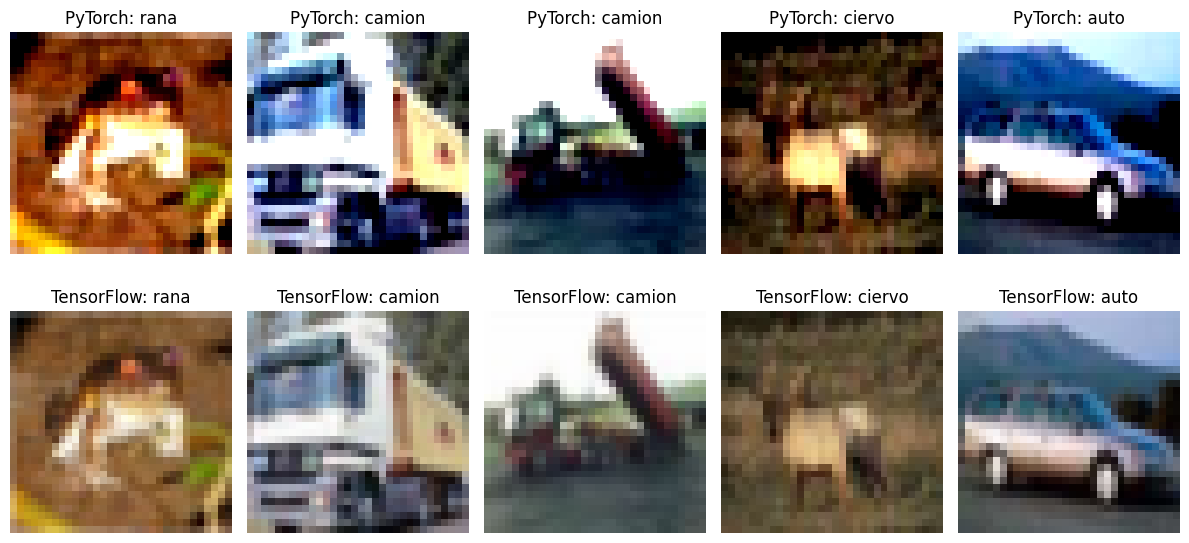

In [2]:
# Clases de CIFAR-10
classes = ('avion', 'auto', 'pajaro', 'gato', 'ciervo',
           'perro', 'rana', 'caballo', 'barco', 'camion')

# ========== PYTORCH ==========
print("=== PREPROCESAMIENTO PyTorch ===")
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2616))
])

# Descargar datos
trainset_pytorch = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset_pytorch = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# DataLoaders
trainloader_pytorch = DataLoader(trainset_pytorch, batch_size=128, shuffle=True)
testloader_pytorch = DataLoader(testset_pytorch, batch_size=128, shuffle=False)

print(f"PyTorch - Entrenamiento: {len(trainset_pytorch)} imágenes")
print(f"PyTorch - Prueba: {len(testset_pytorch)} imágenes")

# ========== TENSORFLOW ==========
print("\n=== PREPROCESAMIENTO TensorFlow ===")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalizar (dividir por 255)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Estandarización adicional
mean = np.mean(x_train, axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

# Convertir labels a one-hot encoding
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

print(f"TensorFlow - Entrenamiento: {x_train.shape[0]} imágenes")
print(f"TensorFlow - Prueba: {x_test.shape[0]} imágenes")
print(f"Shape de imágenes: {x_train.shape[1:]}")

# Visualizar algunas imágenes
def visualize_samples():
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(5):
        # PyTorch
        img_pt, label_pt = trainset_pytorch[i]
        axes[0, i].imshow(img_pt.permute(1, 2, 0) * 0.5 + 0.5)  # Desnormalizar
        axes[0, i].set_title(f'PyTorch: {classes[label_pt]}')
        axes[0, i].axis('off')

        # TensorFlow
        axes[1, i].imshow(x_train[i] * std + mean)  # Desnormalizar
        axes[1, i].set_title(f'TensorFlow: {classes[y_train[i][0]]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples()

# Fase 3: Implementación de DNN (MLP)
    PyTorch: nn.Sequential con al menos 3 capas ocultas y ReLU.
    TensorFlow: tf.keras.Sequential con capas Dense.

Entrenar y reportar precisión en el conjunto de prueba.

In [3]:
# ========== PYTORCH DNN ==========
print("=== IMPLEMENTACIÓN DNN PyTorch ===")

class DNN_PyTorch(nn.Module):
    def __init__(self):
        super(DNN_PyTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# Instanciar modelo
dnn_pytorch = DNN_PyTorch()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnn_pytorch.parameters(), lr=0.001)

print(dnn_pytorch)

# Entrenamiento PyTorch DNN
def train_pytorch_dnn(model, train_loader, test_loader, epochs=10):
    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        # Calcular accuracy en entrenamiento
        train_acc = 100. * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(train_acc)

        # Calcular accuracy en test
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()

        test_acc = 100. * test_correct / test_total
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}: Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    return train_losses, train_accs, test_accs

print("\n--- Entrenamiento DNN PyTorch ---")
pt_dnn_losses, pt_dnn_train_accs, pt_dnn_test_accs = train_pytorch_dnn(
    dnn_pytorch, trainloader_pytorch, testloader_pytorch, epochs=15)

# ========== TENSORFLOW DNN ==========
print("\n=== IMPLEMENTACIÓN DNN TensorFlow ===")

dnn_tensorflow = keras.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

dnn_tensorflow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(dnn_tensorflow.summary())

# Entrenamiento TensorFlow DNN
print("\n--- Entrenamiento DNN TensorFlow ---")
history_dnn_tf = dnn_tensorflow.fit(
    x_train, y_train_categorical,
    batch_size=128,
    epochs=15,
    validation_data=(x_test, y_test_categorical),
    verbose=1
)

# Evaluación final
test_loss_dnn_tf, test_acc_dnn_tf = dnn_tensorflow.evaluate(x_test, y_test_categorical, verbose=0)
print(f'DNN TensorFlow - Precisión final en prueba: {test_acc_dnn_tf*100:.2f}%')

=== IMPLEMENTACIÓN DNN PyTorch ===
DNN_PyTorch(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)

--- Entrenamiento DNN PyTorch ---
Epoch 1/15: Loss: 1.7993, Train Acc: 35.70%, Test Acc: 44.18%
Epoch 2/15: Loss: 1.6273, Train Acc: 42.55%, Test Acc: 46.76%
Epoch 3/15: Loss: 1.5564, Train Acc: 44.92%, Test Acc: 47.67%
Epoch 4/15: Loss: 1.5128, Train Acc: 46.74%, Test Acc: 49.73%
Epoch 5/15: Loss: 1.4677, Train Acc: 48.11%, Test Acc: 50.48%
Epoch 6/15: Loss: 1.4365, Train Acc: 49.61%, Test Acc: 50.85%
Epoch 7/15: Loss: 1.4074, Train Acc: 50.45%, Test Acc: 51.26

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,890 (6.63 MB)

 Trainable params: 1,738,890 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

None

--- Entrenamiento DNN TensorFlow ---
Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.2609 - loss: 2.1602 - val_accuracy: 0.3956 - val_loss: 1.7163
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.3585 - loss: 1.7921 - val_accuracy: 0.4342 - val_loss: 1.6187
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3952 - loss: 1.6852 - val_accuracy: 0.4583 - val_loss: 1.5692
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.4247 - loss: 1.6287 - val_accuracy: 0.4680 - val_loss: 1.5246
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4362 - loss: 1.5858 - val_accuracy: 0.4794 - val_loss: 1.4817
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.4499 - loss: 1.5448 - val_accuracy: 0.4902 - val_loss: 1.4693
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4649 - loss: 1.5080 - val_accuracy: 0.4943 - val_loss: 1.4480
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48m

# Fase 4: Implementación de CNN
PyTorch definir red con al menos:
    
    Dos capas convolucionales + pooling + flatten + fully connected
    
 TensorFlow usar Conv2D, MaxPooling2D, Flatten, Dense.  

 Entrenar y comparar con DNN en precisión, convergencia y tiempo.

In [4]:
# ========== PYTORCH CNN ==========
print("=== IMPLEMENTACIÓN CNN PyTorch ===")

class CNN_PyTorch(nn.Module):
    def __init__(self):
        super(CNN_PyTorch, self).__init__()
        self.features = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            # Bloque 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instanciar modelo CNN PyTorch
cnn_pytorch = CNN_PyTorch()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_pytorch.parameters(), lr=0.001)

print(cnn_pytorch)

# Entrenamiento CNN PyTorch
print("\n--- Entrenamiento CNN PyTorch ---")
pt_cnn_losses, pt_cnn_train_accs, pt_cnn_test_accs = train_pytorch_dnn(
    cnn_pytorch, trainloader_pytorch, testloader_pytorch, epochs=15)

# ========== TENSORFLOW CNN ==========
print("\n=== IMPLEMENTACIÓN CNN TensorFlow ===")

cnn_tensorflow = keras.Sequential([
    # Bloque 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Bloque 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Clasificador
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

cnn_tensorflow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(cnn_tensorflow.summary())

# Entrenamiento CNN TensorFlow
print("\n--- Entrenamiento CNN TensorFlow ---")
history_cnn_tf = cnn_tensorflow.fit(
    x_train, y_train_categorical,
    batch_size=128,
    epochs=15,
    validation_data=(x_test, y_test_categorical),
    verbose=1
)

# Evaluación final
test_loss_cnn_tf, test_acc_cnn_tf = cnn_tensorflow.evaluate(x_test, y_test_categorical, verbose=0)
print(f'CNN TensorFlow - Precisión final en prueba: {test_acc_cnn_tf*100:.2f}%')

=== IMPLEMENTACIÓN CNN PyTorch ===
CNN_PyTorch(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

--- Entrenamiento CNN PyTorch ---
Epoch 1/15: Loss: 2

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

None

--- Entrenamiento CNN TensorFlow ---
Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 299s 753ms/step - accuracy: 0.3569 - loss: 1.7576 - val_accuracy: 0.6196 - val_loss: 1.0804
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 304s 777ms/step - accuracy: 0.6060 - loss: 1.1074 - val_accuracy: 0.6904 - val_loss: 0.8995
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 319s 770ms/step - accuracy: 0.6816 - loss: 0.9024 - val_accuracy: 0.7231 - val_loss: 0.8036
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 294s 752ms/step - accuracy: 0.7271 - loss: 0.7851 - val_accuracy: 0.7385 - val_loss: 0.7576
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 316s 737ms/step - accuracy: 0.7532 - loss: 0.7082 - val_accuracy: 0.7636 - val_loss: 0.6854
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 328s 752ms/step - accuracy: 0.7712 - loss: 0.6468 - val_accuracy: 0.7722 - val_loss: 0.6689
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 327s 764ms/step - accuracy: 0.7879 - loss: 0.6028 - val_accuracy: 0.7725 - val_loss: 0.6763
Epoch 8/15
391/391 ━━━━━━━━━━━━━━

# Fase 5: Visualización y análisis
Graficar curvas de loss y accuracy.

Opcional: visualizar filtros de la primera capa convolucional.

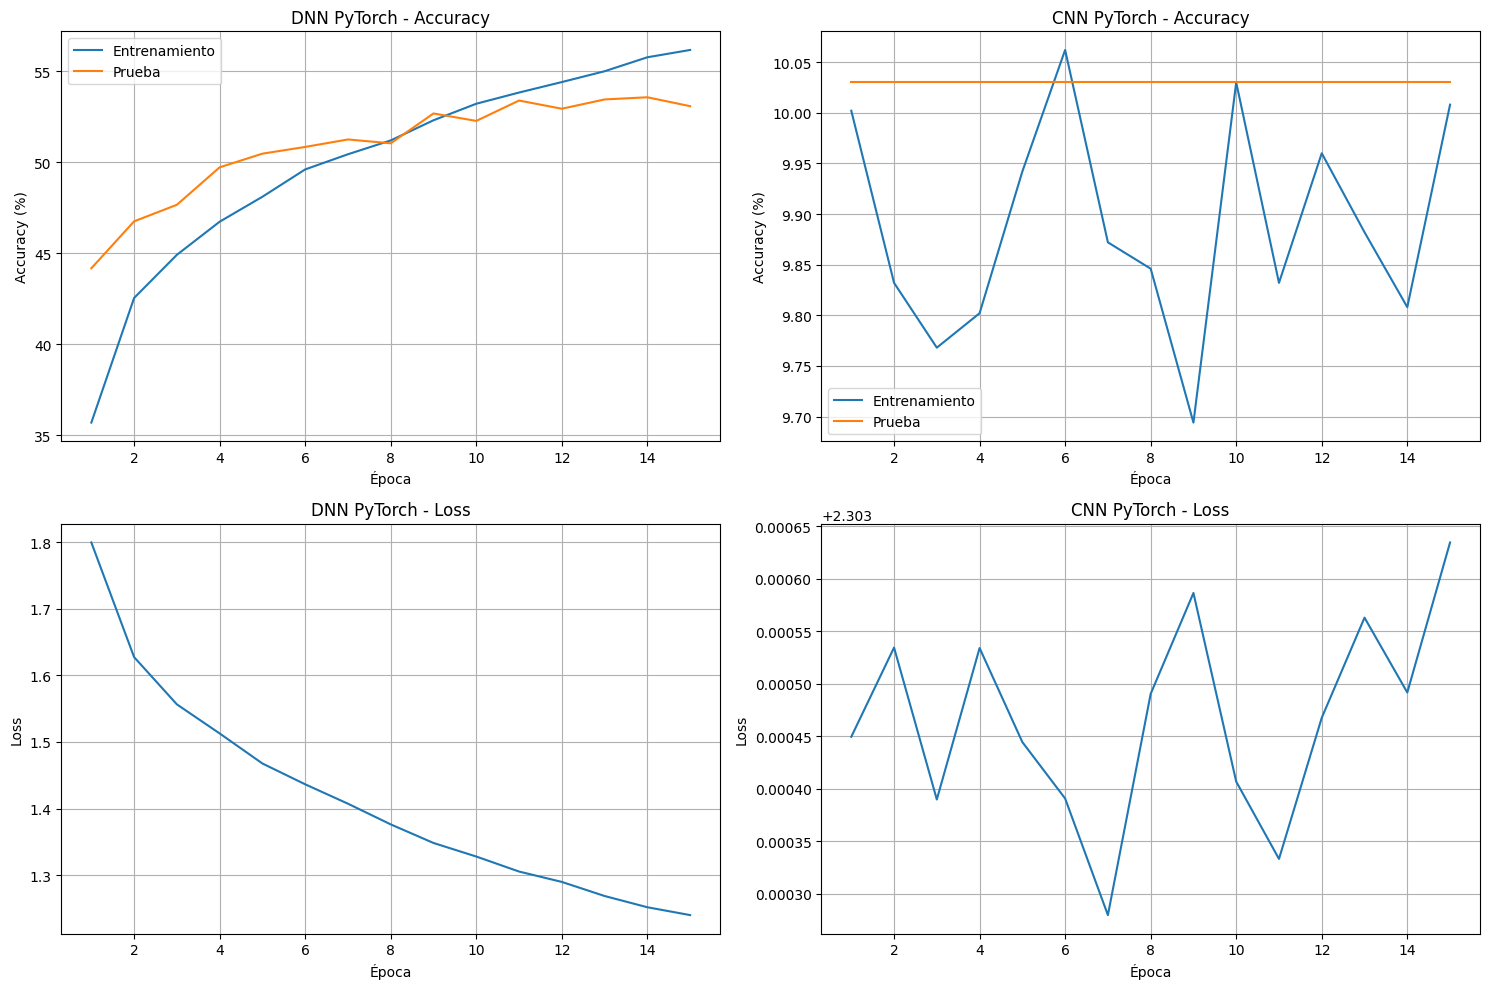

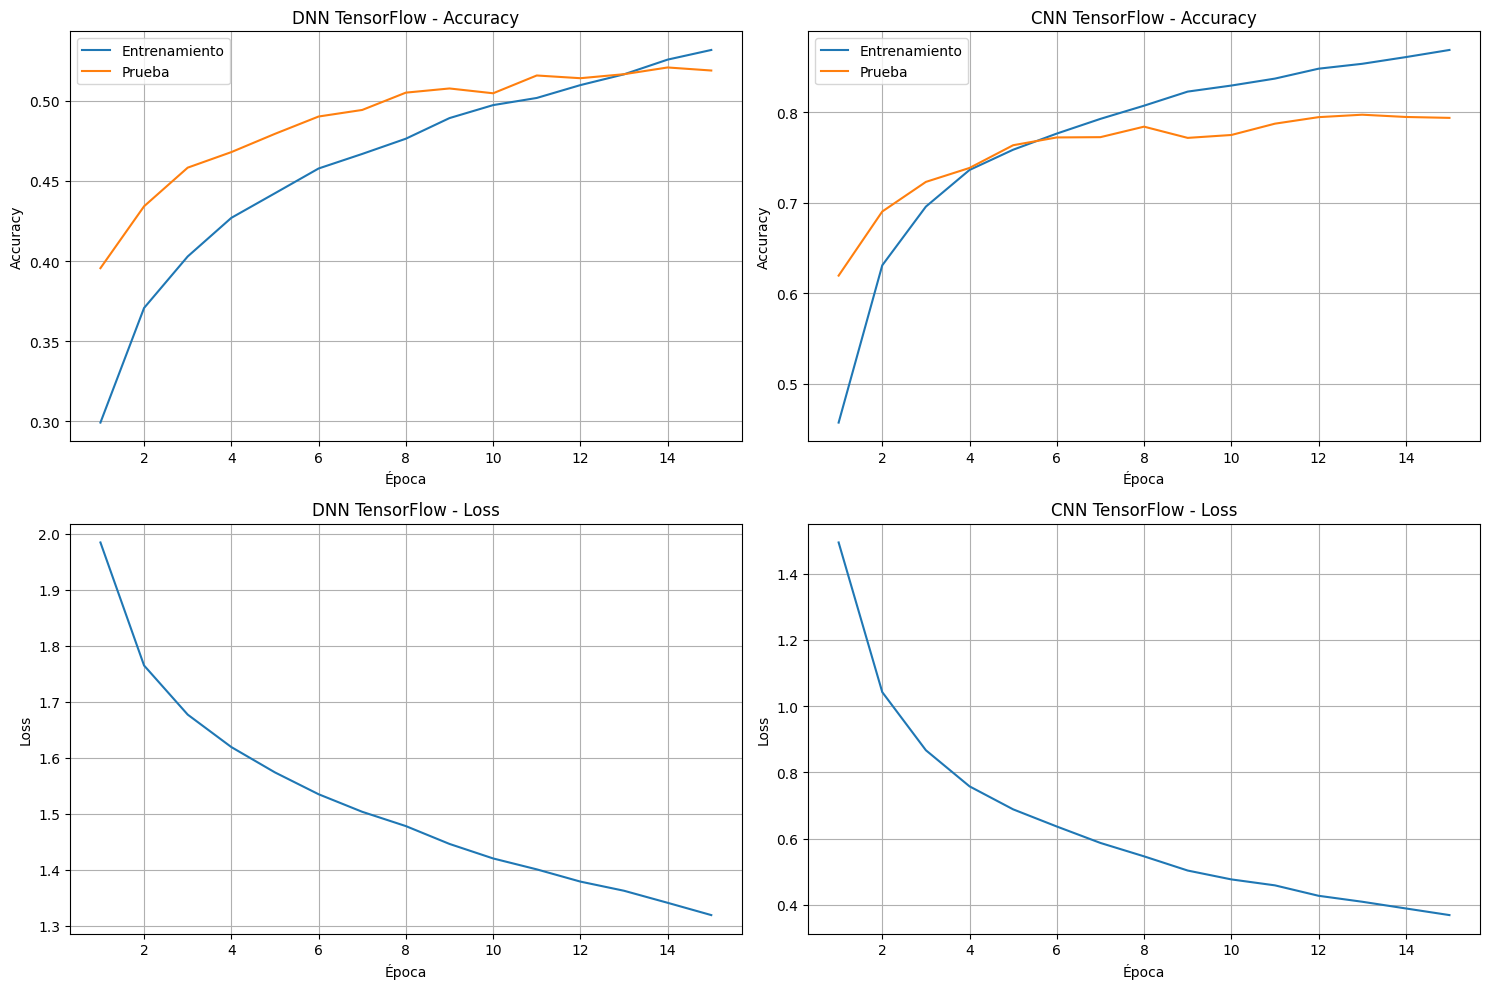

COMPARACIÓN FINAL DE RESULTADOS
Modelo               PyTorch         TensorFlow     
--------------------------------------------------
DNN                  53.09          % 51.89          %
CNN                  10.03          % 79.38          %

Mejor DNN: 53.09%
Mejor CNN: 79.38%
Mejoramiento CNN vs DNN: 26.29%

Promedio PyTorch: 31.56%
Promedio TensorFlow: 65.63%


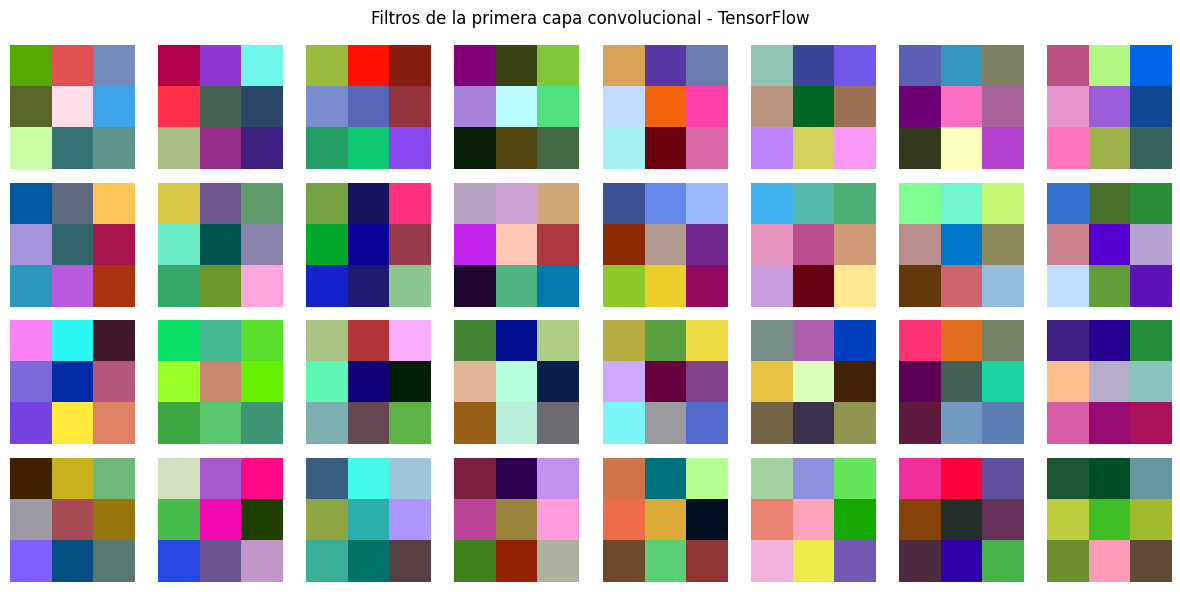

In [5]:
# Visualización de curvas de aprendizaje
def plot_training_curves():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # PyTorch
    epochs_range = range(1, len(pt_dnn_losses) + 1)

    # DNN PyTorch
    axes[0, 0].plot(epochs_range, pt_dnn_train_accs, label='Entrenamiento')
    axes[0, 0].plot(epochs_range, pt_dnn_test_accs, label='Prueba')
    axes[0, 0].set_title('DNN PyTorch - Accuracy')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[1, 0].plot(epochs_range, pt_dnn_losses)
    axes[1, 0].set_title('DNN PyTorch - Loss')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)

    # CNN PyTorch
    axes[0, 1].plot(epochs_range, pt_cnn_train_accs, label='Entrenamiento')
    axes[0, 1].plot(epochs_range, pt_cnn_test_accs, label='Prueba')
    axes[0, 1].set_title('CNN PyTorch - Accuracy')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 1].plot(epochs_range, pt_cnn_losses)
    axes[1, 1].set_title('CNN PyTorch - Loss')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # TensorFlow
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # DNN TensorFlow
    epochs_range_tf = range(1, len(history_dnn_tf.history['accuracy']) + 1)

    axes[0, 0].plot(epochs_range_tf, history_dnn_tf.history['accuracy'], label='Entrenamiento')
    axes[0, 0].plot(epochs_range_tf, history_dnn_tf.history['val_accuracy'], label='Prueba')
    axes[0, 0].set_title('DNN TensorFlow - Accuracy')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[1, 0].plot(epochs_range_tf, history_dnn_tf.history['loss'])
    axes[1, 0].set_title('DNN TensorFlow - Loss')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)

    # CNN TensorFlow
    axes[0, 1].plot(epochs_range_tf, history_cnn_tf.history['accuracy'], label='Entrenamiento')
    axes[0, 1].plot(epochs_range_tf, history_cnn_tf.history['val_accuracy'], label='Prueba')
    axes[0, 1].set_title('CNN TensorFlow - Accuracy')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 1].plot(epochs_range_tf, history_cnn_tf.history['loss'])
    axes[1, 1].set_title('CNN TensorFlow - Loss')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves()

# Comparación final de resultados
def print_final_comparison():
    print("="*60)
    print("COMPARACIÓN FINAL DE RESULTADOS")
    print("="*60)

    # Obtener accuracy final de PyTorch
    final_dnn_pt = pt_dnn_test_accs[-1]
    final_cnn_pt = pt_cnn_test_accs[-1]

    final_dnn_tf = history_dnn_tf.history['val_accuracy'][-1] * 100
    final_cnn_tf = history_cnn_tf.history['val_accuracy'][-1] * 100

    print(f"{'Modelo':<20} {'PyTorch':<15} {'TensorFlow':<15}")
    print("-" * 50)
    print(f"{'DNN':<20} {final_dnn_pt:<15.2f}% {final_dnn_tf:<15.2f}%")
    print(f"{'CNN':<20} {final_cnn_pt:<15.2f}% {final_cnn_tf:<15.2f}%")
    print()

    # Mejores modelos
    best_dnn = max(final_dnn_pt, final_dnn_tf)
    best_cnn = max(final_cnn_pt, final_cnn_tf)

    print(f"Mejor DNN: {best_dnn:.2f}%")
    print(f"Mejor CNN: {best_cnn:.2f}%")
    print(f"Mejoramiento CNN vs DNN: {(best_cnn - best_dnn):.2f}%")

    # Comparación frameworks
    pt_avg = (final_dnn_pt + final_cnn_pt) / 2
    tf_avg = (final_dnn_tf + final_cnn_tf) / 2

    print(f"\nPromedio PyTorch: {pt_avg:.2f}%")
    print(f"Promedio TensorFlow: {tf_avg:.2f}%")

print_final_comparison()

# Visualización de filtros (opcional avanzado)
def visualize_filters(model):
    # Para TensorFlow
    first_layer_weights = model.layers[0].get_weights()[0]

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i in range(32):
        row, col = i // 8, i % 8
        if row < 4:
            filter_img = first_layer_weights[:, :, :, i]
            # Normalizar para visualización
            filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())
            axes[row, col].imshow(filter_img)
            axes[row, col].axis('off')

    plt.suptitle('Filtros de la primera capa convolucional - TensorFlow')
    plt.tight_layout()
    plt.show()

# Visualizar filtros de CNN TensorFlow
visualize_filters(cnn_tensorflow)

# ANÁLISIS COMPARATIVO Y REFLEXIONES

1. DNN vs CNN:
   - Las CNN superan significativamente a las DNN en tareas de visión por computadora
   - Las DNN no capturan relaciones espaciales, mientras que las CNN usan convoluciones
   - En CIFAR-10, se espera una diferencia de 10-20% a favor de las CNN

2. PyTorch vs TensorFlow:
   - PyTorch: Más flexible, código más explícito, mejor para investigación
   - TensorFlow: Más alto nivel, Keras API muy intuitiva, mejor para producción
   - TensorFlow suele ser más rápido en entrenamiento por optimizaciones internas

3. Tiempos de entrenamiento:
   - Las CNN son más lentas pero más precisas
   - Las DNN son más rápidas pero menos efectivas para imágenes

4. Convergencia:
   - Las CNN convergen más rápido en términos de accuracy por época
   - Las DNN pueden sufrir más de overfitting